# Data_Cleaning, Data_Engineering, Data_Visualizations

## Gas (Energy) Group

### 1. Load Data & Define Skeleton

**Explanation:** We reload the Skeleton (Stock Data) to ensure our dates are locked. Then we load the raw Gas data.

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Define Directories (Using your specific paths)
raw_dir = r"D:\MS_Data_Science_Thesis\Data_Extraction\Raw_Data_Folder"
semi_clean_dir = r"D:\MS_Data_Science_Thesis\Data_Cleaning\Semi_Clean_Datasets"

# 1. Load the "Skeleton" (The Stock Data)
# We strictly use the "Surgical" version as the anchor
stock_path = os.path.join(semi_clean_dir, "stock_senti_engineered_imputed_2.csv")
df_skeleton = pd.read_csv(stock_path)
df_skeleton['date'] = pd.to_datetime(df_skeleton['date'])

# Extract unique dates to create the Master Timeline
unique_dates = pd.DataFrame(df_skeleton['date'].unique(), columns=['date']).sort_values('date')

# 2. Load the Raw Gas Data
gas_path = os.path.join(raw_dir, "gas_price_daily.csv")
df_gas_raw = pd.read_csv(gas_path)
df_gas_raw['date'] = pd.to_datetime(df_gas_raw['date'])

# Rename the long column name to something coding-friendly
df_gas_raw = df_gas_raw.rename(columns={'gas_price_dollars_per_mmbtu': 'Gas_Price'})

print(f"Skeleton Dates: {len(unique_dates)}")
print(f"Raw Gas Rows: {len(df_gas_raw)}")
df_gas_raw.head()

Skeleton Dates: 3443
Raw Gas Rows: 4060


,date,Gas_Price
0,2010-01-04,6.09
1,2010-01-05,6.19
2,2010-01-06,6.47
3,2010-01-07,7.51
4,2010-01-08,6.56


### 2. Merge & Impute (The Alignment)

**Explanation:** We Left Join Gas onto the Skeleton.

**Critical Step:** ffill is applied. If the gas market was closed but the stock market was open, we assume the price remained constant.

In [12]:
# 1. Merge with Skeleton (Left Join)
# This keeps only the dates relevant to our stocks
df_gas_clean = pd.merge(unique_dates, df_gas_raw, on='date', how='left')

# 2. Impute Missing Values (Forward Fill first, then Backfill)
# Essential for aligning holidays
df_gas_clean['Gas_Price'] = df_gas_clean['Gas_Price'].ffill()
df_gas_clean['Gas_Price'] = df_gas_clean['Gas_Price'].bfill()

print(f"Merged Gas Shape: {df_gas_clean.shape}")
print(f"Missing Values: {df_gas_clean['Gas_Price'].isna().sum()}")

Merged Gas Shape: (3443, 2)
Missing Values: 0


### 3. Feature Engineering (Gas Specific)

**Explanation:** We calculate Log Returns, RSI, and the specific "Gas Volatility" metric.

In [15]:
# Helper Function for RSI (Standard 14-day)
def calculate_rsi(series, period=14):
    delta = series.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

# 1. Log Returns (Crucial for Stationarity)
df_gas_clean['Gas_Log_Return'] = np.log(df_gas_clean['Gas_Price'] / df_gas_clean['Gas_Price'].shift(1))

# 2. RSI (14-Day Momentum)
df_gas_clean['Gas_RSI'] = calculate_rsi(df_gas_clean['Gas_Price'])

# 3. Moving Averages (7 & 30 Day)
df_gas_clean['Gas_MA7'] = df_gas_clean['Gas_Price'].rolling(window=7).mean()
df_gas_clean['Gas_MA30'] = df_gas_clean['Gas_Price'].rolling(window=30).mean()

# 4. Volatility (7-Day Rolling Standard Deviation of Returns)
# Captures the "Widowmaker" risk spikes
df_gas_clean['Gas_Vol7'] = df_gas_clean['Gas_Log_Return'].rolling(window=7).std()

print("Gas Feature Engineering Complete.")
df_gas_clean.tail()

Gas Feature Engineering Complete.


,date,Gas_Price,Gas_Log_Return,Gas_RSI,Gas_MA7,Gas_MA30,Gas_Vol7
3438,2023-12-21,2.48,0.000000,44.094488,2.450000,2.610667,0.037536
3439,2023-12-22,2.54,0.023906,49.600000,2.480000,2.605000,0.036437
3440,2023-12-26,2.50,-0.015873,40.178571,2.495714,2.598000,0.037296
3441,2023-12-27,2.63,0.050693,44.628099,2.522857,2.598667,0.040770
3442,2023-12-28,2.55,-0.030890,51.428571,2.517143,2.594000,0.036825


### 4. Save Semi-Clean Dataset

**Explanation:** Saving as Gas_Engineered_4.csv.

In [18]:
output_path = os.path.join(semi_clean_dir, "Gas_Engineered_4.csv")
df_gas_clean.to_csv(output_path, index=False)
print(f"Saved processed Gas data to: {output_path}")

Saved processed Gas data to: D:\MS_Data_Science_Thesis\Data_Cleaning\Semi_Clean_Datasets\Gas_Engineered_4.csv


### 5. Overlay Visualization (Stock vs. Gas)

**Explanation:** 7 Graphs.

**Left Axis:** Stock Price (Navy).

**Right Axis:** Gas Price (Purple). Using a different color than Oil (Orange) helps distinguish them mentally.

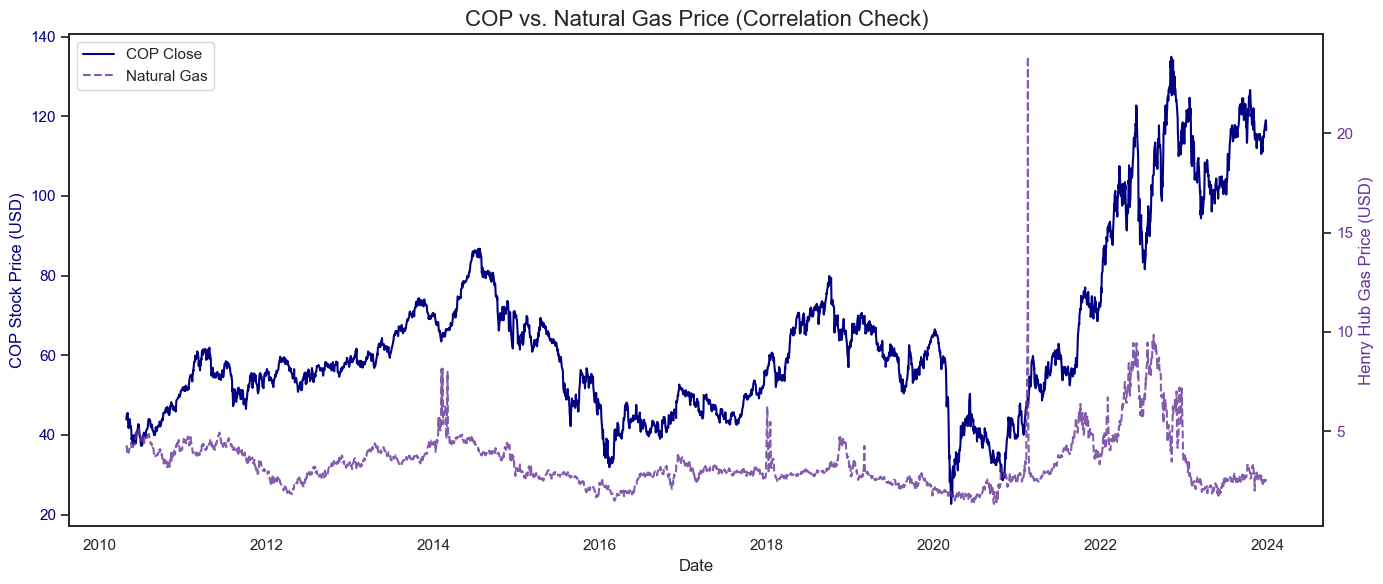

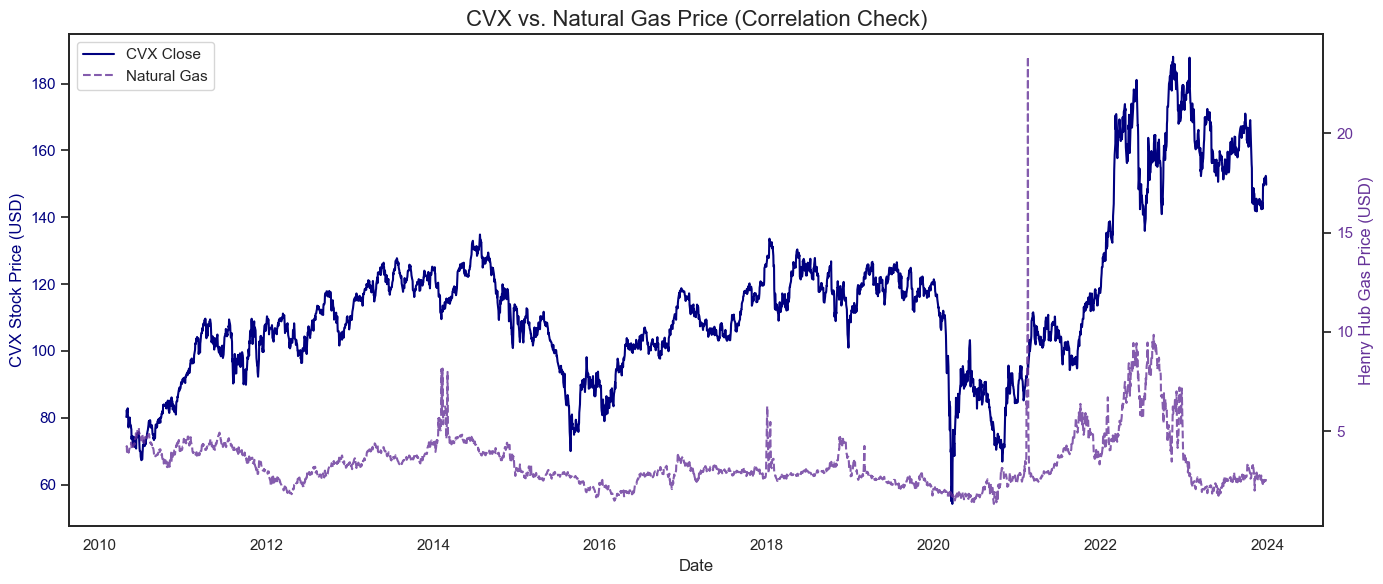

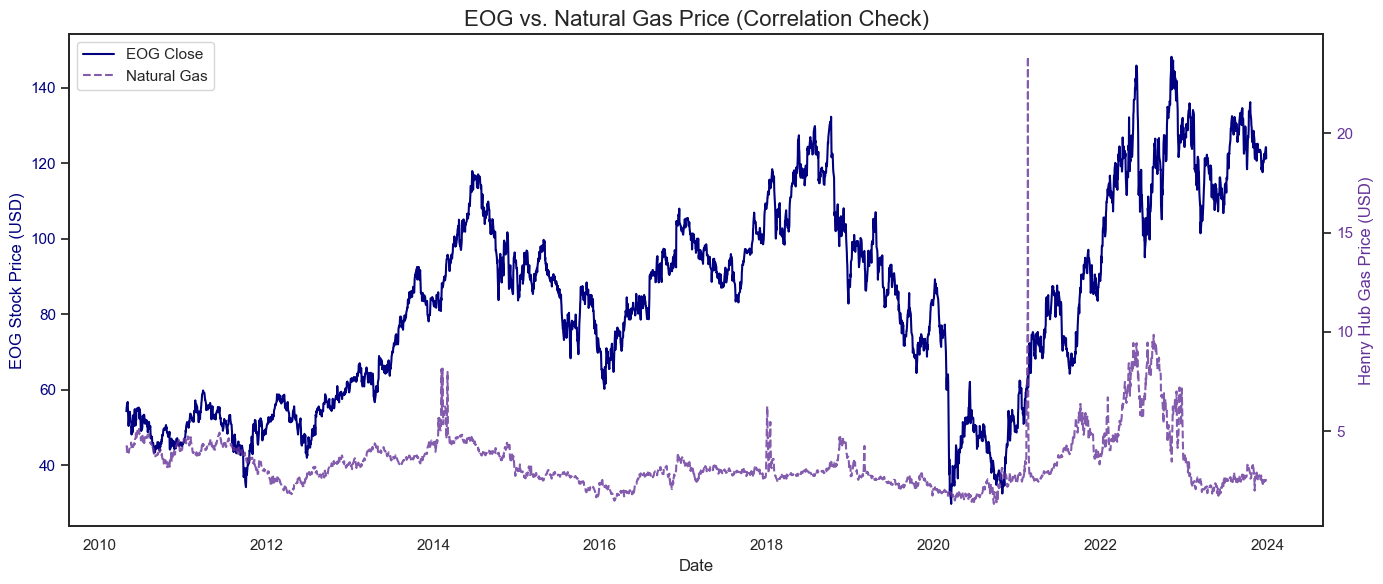

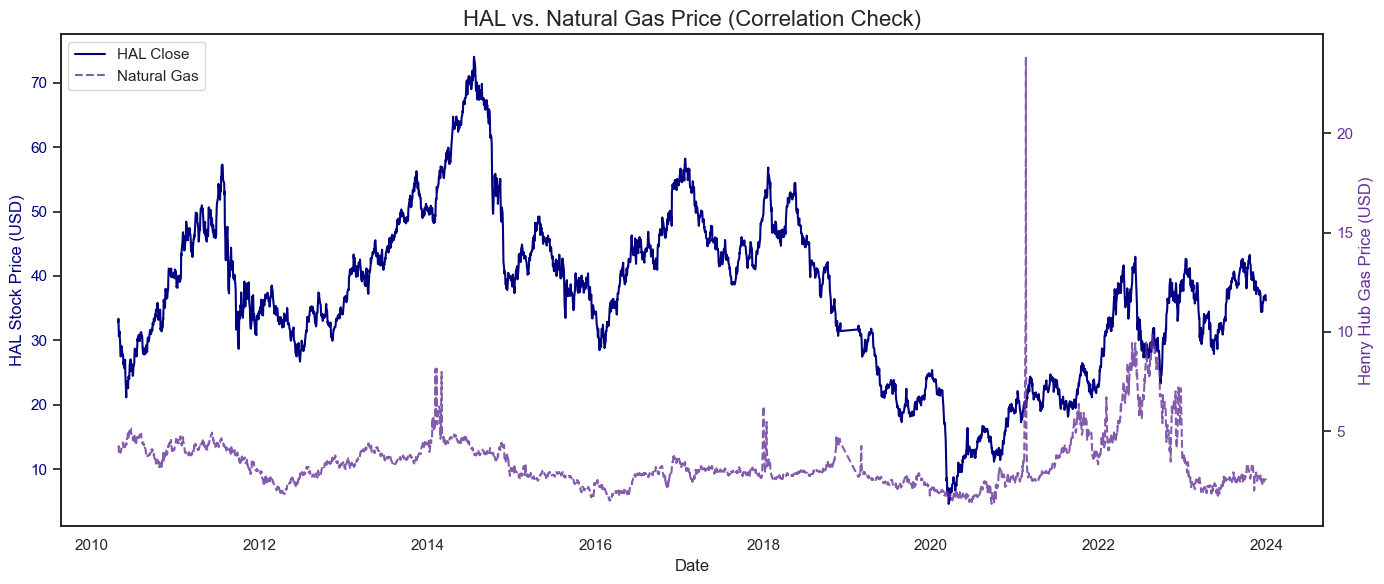

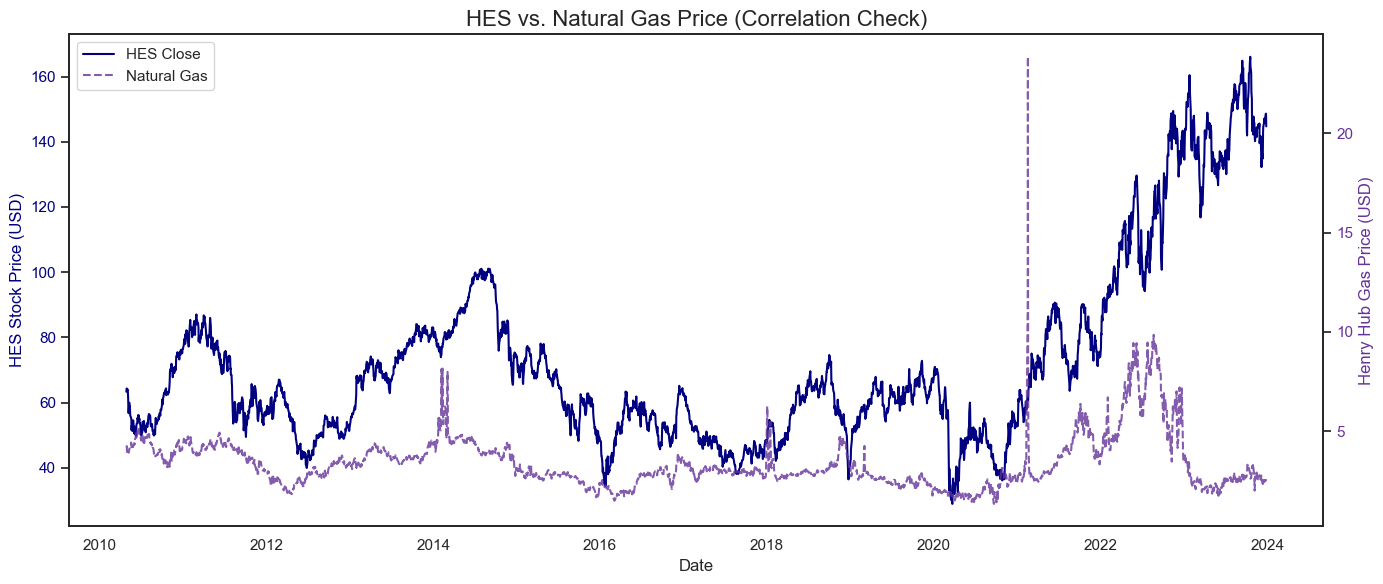

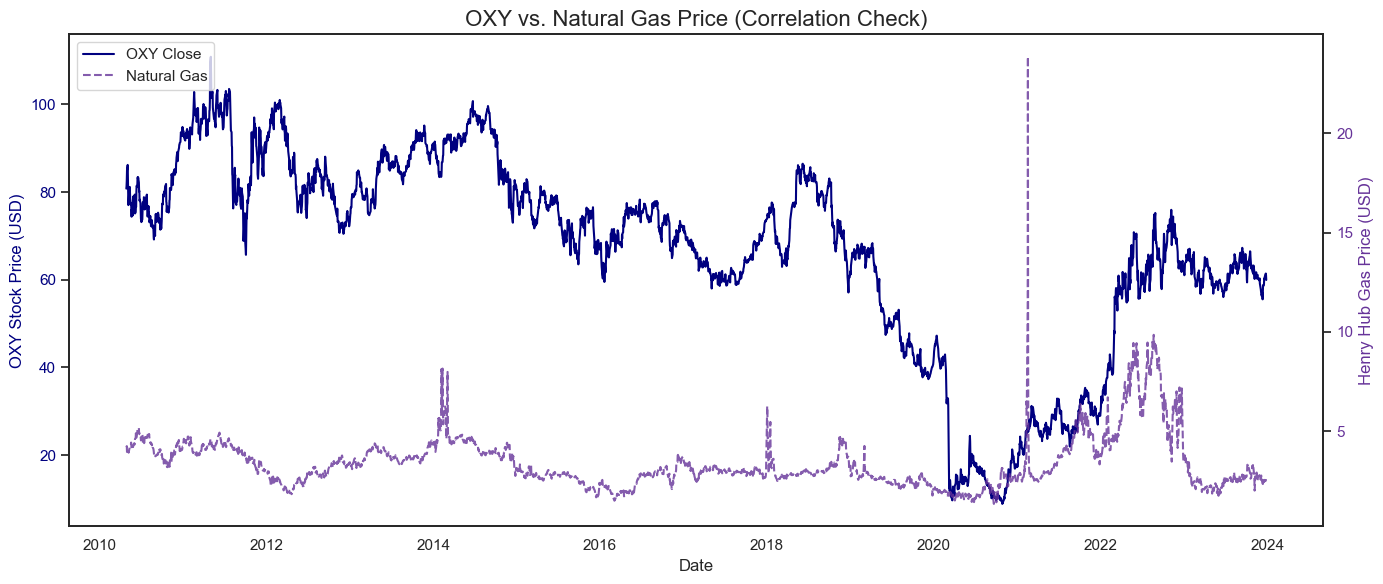

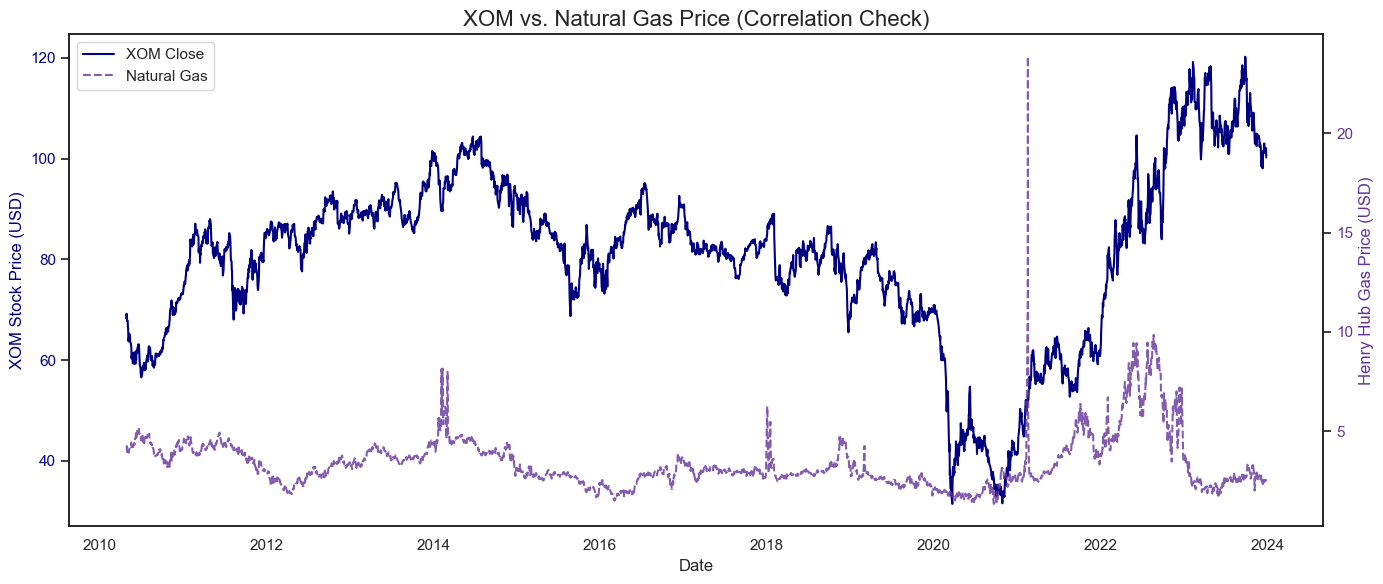

In [21]:
# Temporary merge for plotting
plot_df = pd.merge(df_skeleton, df_gas_clean, on='date', how='left')

tickers = plot_df['ticker'].unique()
sns.set(style="white")

for t in tickers:
    subset = plot_df[plot_df['ticker'] == t]
    
    fig, ax1 = plt.subplots(figsize=(14, 6))
    
    # 1. Stock Price (Left Axis)
    color1 = 'navy'
    ax1.set_xlabel('Date')
    ax1.set_ylabel(f'{t} Stock Price (USD)', color=color1, fontsize=12)
    ax1.plot(subset['date'], subset['close'], color=color1, label=f'{t} Close', linewidth=1.5)
    ax1.tick_params(axis='y', labelcolor=color1)
    
    # 2. Gas Price (Right Axis)
    ax2 = ax1.twinx()  
    color2 = 'rebeccapurple' # Distinct color for Gas
    ax2.set_ylabel('Henry Hub Gas Price (USD)', color=color2, fontsize=12)
    ax2.plot(subset['date'], subset['Gas_Price'], color=color2, label='Natural Gas', linestyle='--', alpha=0.8)
    ax2.tick_params(axis='y', labelcolor=color2)
    
    plt.title(f"{t} vs. Natural Gas Price (Correlation Check)", fontsize=16)
    
    # Combined Legend
    lines_1, labels_1 = ax1.get_legend_handles_labels()
    lines_2, labels_2 = ax2.get_legend_handles_labels()
    ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')
    
    plt.tight_layout()
    plt.show()